In [1]:
%matplotlib inline

In [2]:
from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
#from mayavi import mlab
import seaborn as sns
from vtk_rw import read_vtk, write_vtk
from plotting import plot_surf_stat_map

/scr/ilz1/cbspython_surf/surfenv/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
def make_cmap(c):
    #cmap = np.asarray(sns.cubehelix_palette(c-1, start=.5, rot=-.75, reverse=True))
    #cmap = np.asarray(sns.color_palette('cubehelix', c-1))
    cmap = np.asarray(sns.color_palette('Reds', c-1))
    cmap = np.concatenate((np.array([[0.4,0.4,0.4]]), cmap), axis=0)
    cmap = np.concatenate((cmap, np.ones((c,1))), axis=1)
    cmap_seaborn = [tuple(cmap[i]) for i in range(len(cmap))]

    cmap_255=np.zeros_like(cmap)
    for row in range(cmap.shape[0]):
        cmap_255[row]=[np.floor(i * 255) for i in cmap[row]]
    cmap_255=cmap_255.astype(int)
    
    return cmap_seaborn, cmap_255

In [4]:
mesh_file='/scr/ilz3/myelinconnect/all_data_on_simple_surf/surfs/lowres_rh_d.vtk'
sulc_file='/scr/ilz3/myelinconnect/all_data_on_simple_surf/surfs/lowres_rh_sulc.npy'
mask_file='/scr/ilz3/myelinconnect/all_data_on_simple_surf/masks/rh_mask.npy'
data_file='/scr/ilz3/myelinconnect/all_data_on_simple_surf/missampled/corr/rh_smooth_3_thr_per_session_corr_rowsum.npy'

In [8]:
data=np.load(data_file)
sulc=np.load(sulc_file)
mask=np.load(mask_file)
data[mask]=0
v, f, d = read_vtk(mesh_file)

In [42]:
data_masked=np.delete(data, mask)
data_norm=(data_masked-np.mean(data_masked))/np.std(data_masked)

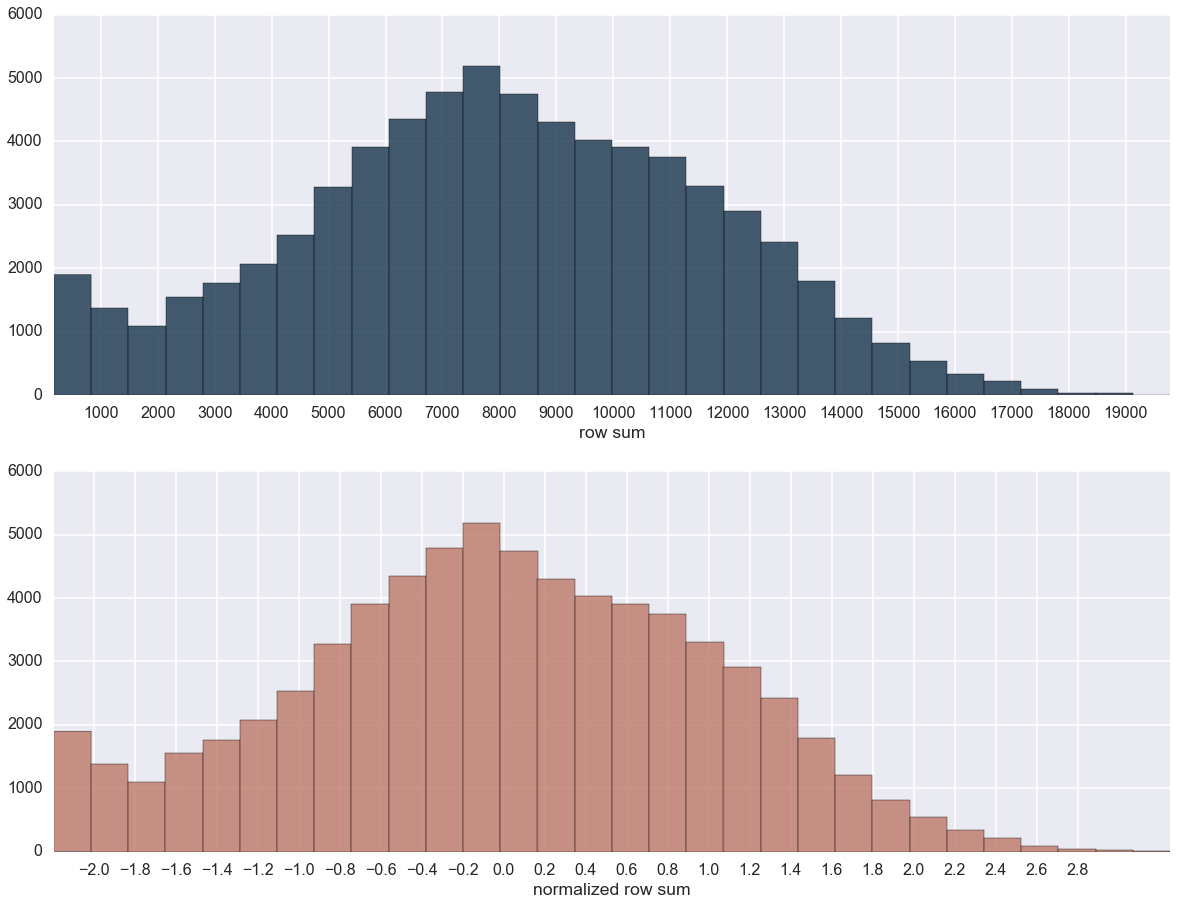

In [62]:
sns.set_context('poster')
sns.set_style('darkgrid')
fig=plt.figure(figsize=(20,15))
fig.add_subplot(211)
plt.hist(data_masked, bins=30, color=sns.color_palette('cubehelix',10)[1], alpha=0.8);
plt.xticks(np.arange(0, max(data_masked)+1, 1000))
plt.xlim(min(data_masked), max(data_masked))
plt.xlabel('row sum')
fig.add_subplot(212)
plt.hist(data_norm, bins=30, color=sns.color_palette('cubehelix',10)[5], alpha=0.8);
plt.xticks(np.arange(-2, +3, 0.2))
plt.xlim(min(data_norm), max(data_norm))
plt.xlabel('normalized row sum')

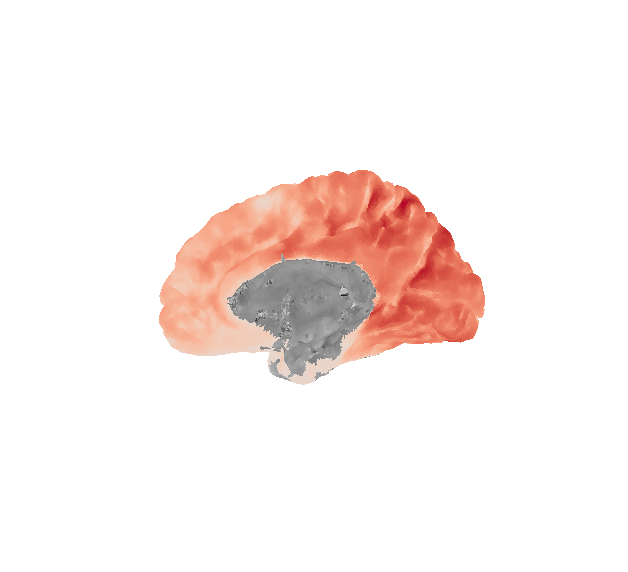

In [65]:
sns.set_style('white')
plot = plot_surf_stat_map(v, f, stat_map=data, threshold=1500, bg_map=sulc, elev=180, azim=180, figsize=(11,10))

In [ ]:
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

plt.imshow(gradient, aspect='auto', cmap=cbar)
plt.axis('off')

In [ ]:
x=v[:,0]
y=v[:,1]
z=v[:,2]
triangles=f
pal, pal_255 = make_cmap(10)

In [ ]:
sns.palplot(pal)

In [ ]:
mlab.figure(bgcolor=(1, 1, 1))
img = mlab.triangular_mesh(x,y,z,triangles,scalars=data, colormap='RdBu')
lut = img.module_manager.scalar_lut_manager.lut.table.to_array()
img.module_manager.scalar_lut_manager.lut.table = pal_255
mlab.draw()
mlab.show()